# Task 2: Baseline Model: Logistics Regression and the effect of data quality

Based on Task 1, we applied the following preprocessing steps to the data. We will therefore replicate the steps for every test/training round in order to validate how the accuracy improves based on different data quality, data cleaning and feature selection process.  

- Step 0: No Preprocessing, no data quality.
    - Drop all NAs. 
- Step 1: Data Quality 
    - Fix grammar error in column "Ctry" (Germayn -> Germany)
- Step 2: Data Imputation 
    - All of the steps in Step 1. 
    - Deletion of entries with missing values in the target colunm
    - Listwise deletion (all rows with multiple missing values, more than 2)
    - Outlier Cleaning
    - Imputation for numerical columns
    - Imputation for categorical columns
        - Imputation using mode
        - Imputation using Predictive model
- Step 3: Data Normalization
    - All of the steps in Step 2. 
    - Normality Check & Quantile Transformation
- Step 4: Feature Engineering
    - All of the steps in Step 3. 
    - Combination of Features
    - Multicoliniarity Test
- Step 5: Dimensionality Reduction
    - All of the steps in Step 4, except the Multicoliniarity Test
    - Apply PCA and keep 95% of variance

In [15]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score


import warnings
warnings.filterwarnings('ignore')

## Functions

In [16]:
def impute_numeric_missing_values_test_data(df_train: pd.DataFrame, 
                                            df_test: pd.DataFrame, 
                                            numeric_columns: list[str]) -> pd.DataFrame:
    """Impute numeric missing values using IQR method
    to first identify outliers and then replace them with median
    use only train data to calculate IQR and median

    Args:
        df (pd.DataFrame): input dataframe
        numeric_columns (list[str]): numeric columns

    Returns:
        pd.DataFrame: cleaned dataframe
    """
    for col in numeric_columns:
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (df_test[col] < (Q1 - 1.5 * IQR)) | (df_test[col] > (Q3 + 1.5 * IQR))
        df_test[col] = df_test[col].mask(outliers, np.nan)
        
        median_from_train = df_train[col].median()
        df_test[col] = df_test[col].fillna(median_from_train)
        
    return df_test

def train_and_evaluate_model(df_train: pd.DataFrame, 
                             df_test: pd.DataFrame, 
                             features: list[str],
                             remove_features: list[str],
                             target_col: str, 
                             cv: int = 5) -> tuple:

    if remove_features:
        features = [x for x in features if x not in remove_features]
        
    X_train = df_train[features]
    y_train = df_train[target_col]
    
    print("Features:", features)
    
    X_test = df_test[features]
    y_test = df_test[target_col]
       
    # Modell erstellen und trainieren
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Modell evaluieren
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print(f"Training Score: {train_score:.3f}")
    print(f"Test Score: {test_score:.3f}")
    
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    f1_score_result = f1_score(y_test, y_pred)
    accuracy_score_result = accuracy_score(y_test, y_pred)
    
    
    print(f"Classification Report: {class_report}")
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
    print(f"Cross Validation Scores: {cv_scores}")
    
    scores = {
        "cv_scores": cv_scores,
        'train_score': train_score,
        'test_score': test_score
        
    }
    
    metrics = {
        "class_report": class_report,
        "conf_matrix": conf_matrix,
        "f1_score": f1_score_result,
        "accuracy_score": accuracy_score_result
    }
    
    return model, features, scores, metrics

def feature_importance_logistic_regression(model: LogisticRegression, features: list[str]) -> pd.DataFrame:
    """Calculate feature importance for logistic regression model

    Args:
        model (LogisticRegression): model
        features (list[str]): feature names

    Returns:
        pd.DataFrame: feature importance
    """
    coef = model.coef_[0]
    feature_importance = pd.DataFrame({
        'feature': features,
        'coeffiecient': coef
    })
    feature_importance['abs_coeffiecient'] = feature_importance['coeffiecient'].abs()
    feature_importance = feature_importance.sort_values(by='abs_coeffiecient', ascending=False)
    return feature_importance

## Prepare Test Data

In [17]:
df_test = pd.read_csv("../../data/raw/triathlon_watch_test_data_final.csv")
df_train = pd.read_csv("../../data/raw/triathlon_watch_training_data_final.csv")

# Rename columns for better handling
df_test.columns = df_test.columns.str.strip().str.lower().str.replace(' ', '_')
df_train.columns = df_train.columns.str.strip().str.lower().str.replace(' ', '_')

category_columns = list(df_test.describe(include='object').columns)
category_columns.remove('id')
category_columns.remove('most_current_software_update')
category_columns.remove('synchronisation')
date_columns = ['most_current_software_update']
bool_columns = ['synchronisation']
target_columns = ['user_of_latest_model']
numeric_columns = df_test.describe().columns
numeric_columns = [x for x in numeric_columns if x not in target_columns]
text_columns = ['id']

print("Category Columns:", category_columns)
print("Date Columns:", date_columns)
print("Boolean Columns:", bool_columns)
print("Numeric Columns:", numeric_columns)
print("Text Columns:", text_columns)
print("Target Columns:", target_columns)

for bool_column in bool_columns:
    df_test[bool_column] = df_test[bool_column].map({'Yes': 1, 'No': 0})
    df_train[bool_column] = df_train[bool_column].map({'Yes': 1, 'No': 0})


Category Columns: ['sex', 'ctry', 'town', 'goal_of_training', 'preferred_training_daytime', 'subscription_type', 'color_of_watch']
Date Columns: ['most_current_software_update']
Boolean Columns: ['synchronisation']
Numeric Columns: ['age_of_customer', 'swimming_hours_per_week', 'biking_hours_per_week', 'running_hours_per_week', 'total_training_hours_per_week', 'vo2_max', '10k_running_time_prediction', 'calories_burned_per_week', 'support_cases_of_customer', 'customer_years']
Text Columns: ['id']
Target Columns: ['user_of_latest_model']


<Axes: >

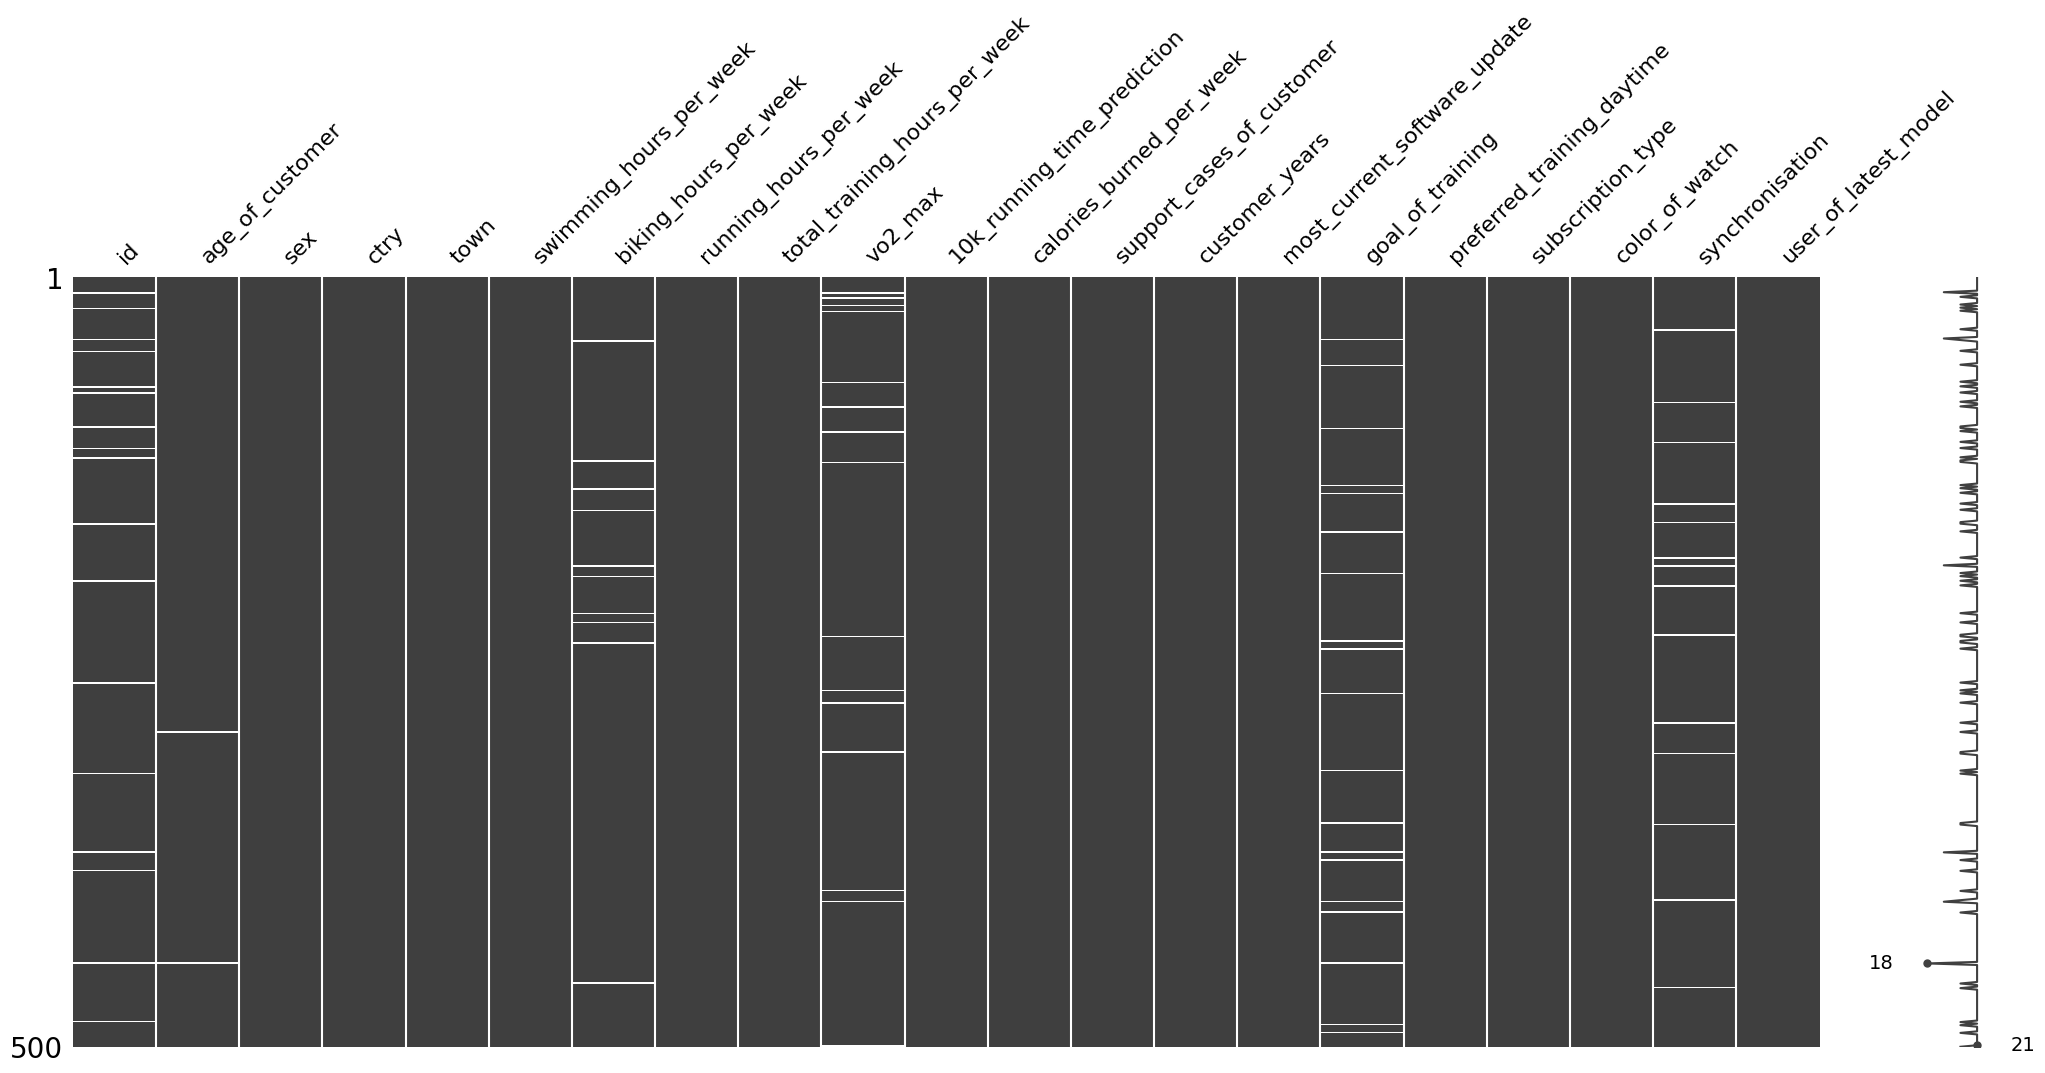

In [18]:
msno.matrix(df_test)

Since the test data is unknown at the moment of prediction, we will fill any missing values using the training data. The approach is the following: 

- Numeric Columns: Remove Outliers using IQR, and filling missing values with median. 
- Categorical Column: Fill missing values using the model.

In [19]:
df_test_org = df_test.copy()
df_train_org = df_train.copy()

### Test data with no data quality issues

In [20]:
# Fix Data Quality Issues
df_test['ctry'] = df_test['ctry'].replace('Germayn', 'Germany')
df_train['ctry'] = df_train['ctry'].replace('Germayn', 'Germany')

# Impute Numeric Columns using Trainig Data
df_test = impute_numeric_missing_values_test_data(df_train, df_test, numeric_columns)   

# Impute Categorical Columns using Trainig Data

cols_to_impute = category_columns + text_columns + bool_columns + date_columns
for col in cols_to_impute:
        print("Impute missing values in column: ", col, " with mode from train data")
        df_test[col] = df_test[col].fillna(df_train[col].mode()[0])
        
assert df_test.isnull().sum().sum() == 0, "There are still missing values in the dataset"
assert df_test.shape[0] == df_test_org.shape[0], "Data loss in test dataset"
df_test.to_csv("../../data/processed/triathlon_watch_test_preprocessed_john.csv", index=False)

Impute missing values in column:  sex  with mode from train data
Impute missing values in column:  ctry  with mode from train data
Impute missing values in column:  town  with mode from train data
Impute missing values in column:  goal_of_training  with mode from train data
Impute missing values in column:  preferred_training_daytime  with mode from train data
Impute missing values in column:  subscription_type  with mode from train data
Impute missing values in column:  color_of_watch  with mode from train data
Impute missing values in column:  id  with mode from train data
Impute missing values in column:  synchronisation  with mode from train data
Impute missing values in column:  most_current_software_update  with mode from train data


### Test data with data quality issues

In [21]:
# Fix Data Quality Issues
df_test = df_test_org.copy()
df_train = df_train_org.copy()

# Impute Numeric Columns using Trainig Data
df_test = impute_numeric_missing_values_test_data(df_train, df_test, numeric_columns)   

# Impute Categorical Columns using Trainig Data

cols_to_impute = category_columns + text_columns + bool_columns + date_columns
for col in cols_to_impute:
        print("Impute missing values in column: ", col, " with mode from train data")
        df_test[col] = df_test[col].fillna(df_train[col].mode()[0])
        
assert df_test.isnull().sum().sum() == 0, "There are still missing values in the dataset"
assert df_test.shape[0] == df_test_org.shape[0], "Data loss in test dataset"
df_test.to_csv("../../data/processed/triathlon_watch_test_preprocessed_john_no_quality.csv", index=False)

Impute missing values in column:  sex  with mode from train data
Impute missing values in column:  ctry  with mode from train data
Impute missing values in column:  town  with mode from train data
Impute missing values in column:  goal_of_training  with mode from train data
Impute missing values in column:  preferred_training_daytime  with mode from train data
Impute missing values in column:  subscription_type  with mode from train data
Impute missing values in column:  color_of_watch  with mode from train data
Impute missing values in column:  id  with mode from train data
Impute missing values in column:  synchronisation  with mode from train data
Impute missing values in column:  most_current_software_update  with mode from train data


<Axes: >

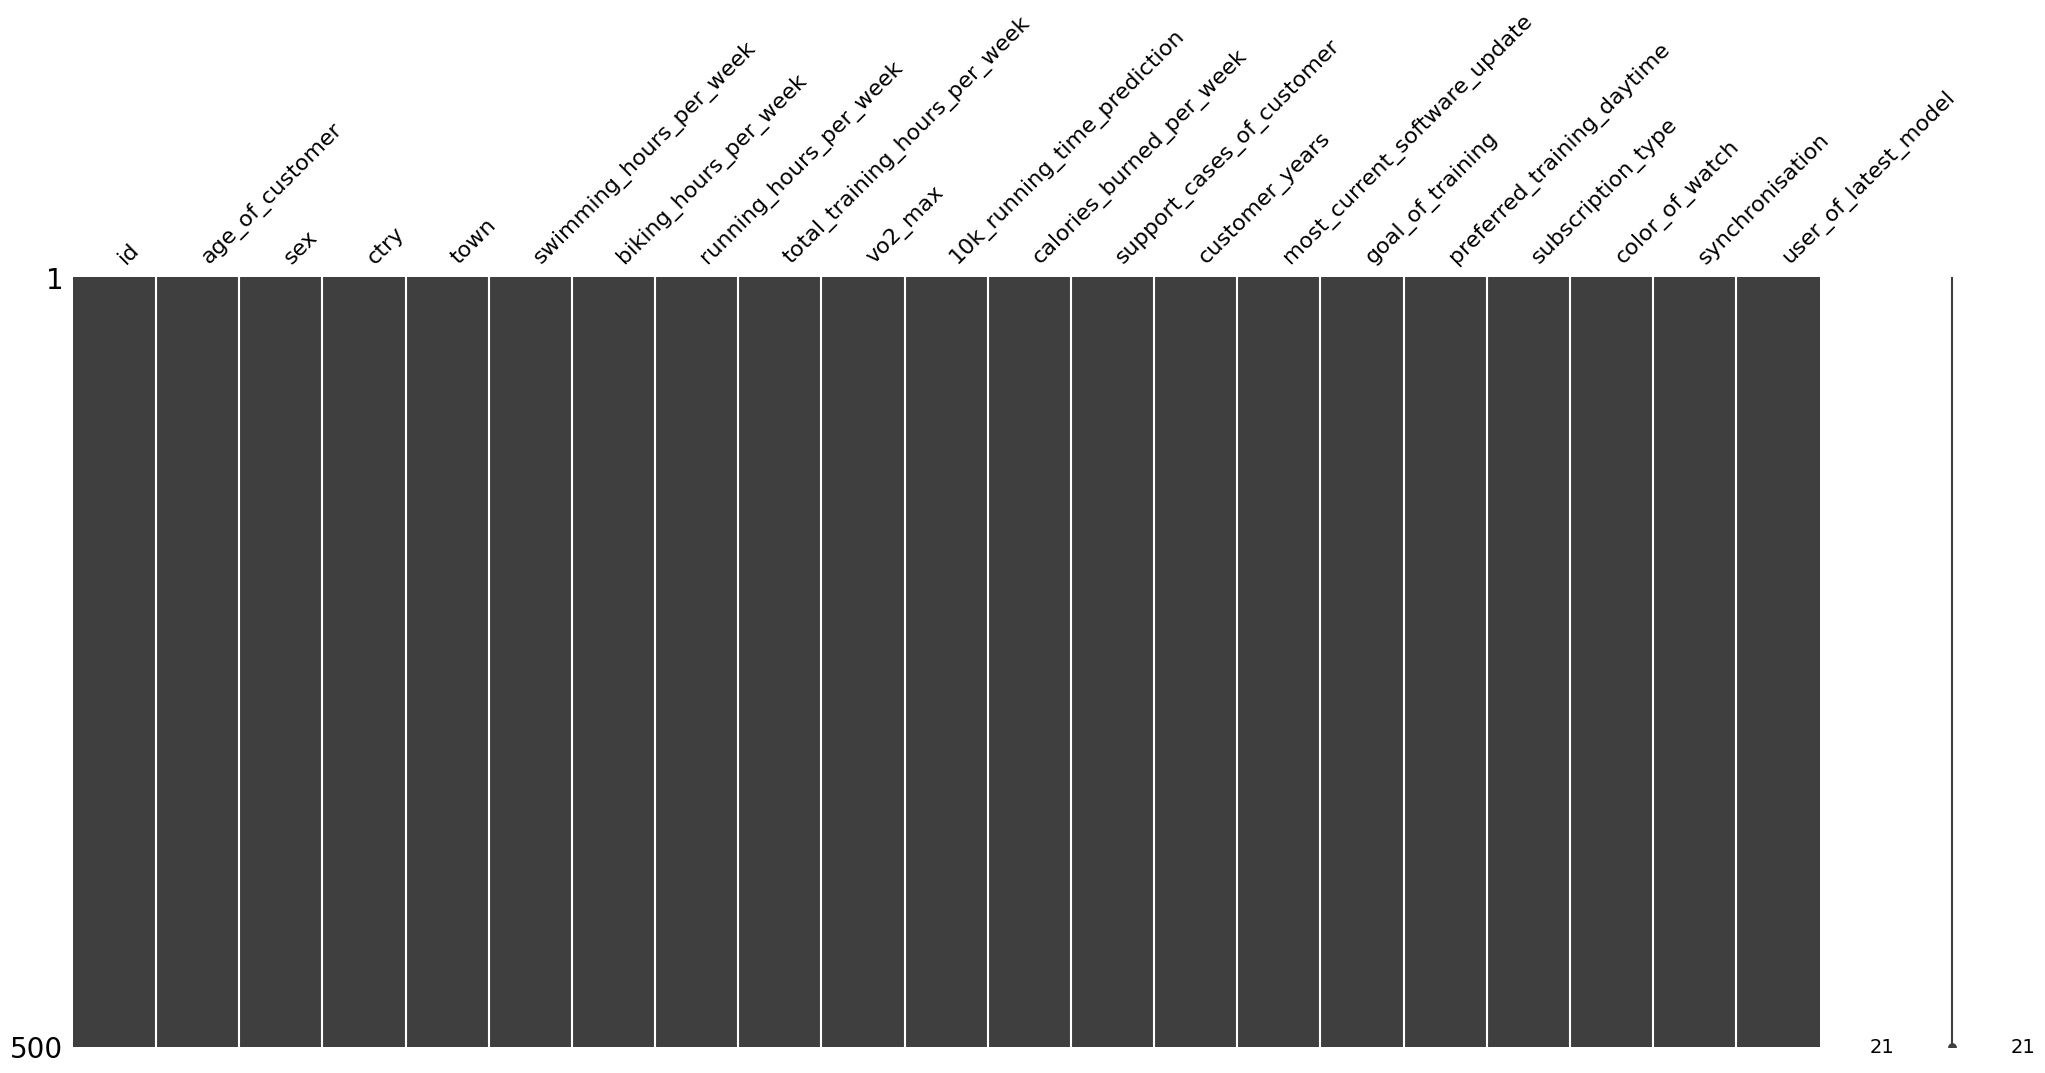

In [22]:
msno.matrix(df_test)

## Model Training

In [23]:
# Dictionary to store all models and metrics data
models_metrics = {}

## Model Step 0: No Preprocessing, no data quality

This scenario covers the fact that the column 'Ctry' contains the invalid value "Germayn" instead of "Germany"

In [24]:
df_test_step_0 = pd.read_csv("../../data/processed/triathlon_watch_test_preprocessed_john_no_quality.csv")

# Add hot encoded features
df_hot_encoded_feat = pd.get_dummies(df_test_step_0.filter(category_columns), 
                                     columns=category_columns, drop_first=True, 
                                     prefix="hot_enc_", dtype=int)
df_test_step_0 = pd.concat([df_test_step_0, df_hot_encoded_feat], axis=1)
df_test_step_0 = df_test_step_0.drop(category_columns + text_columns, axis=1)

df_train_step_0 = pd.read_csv("../../data/processed/triathlon_watch_training_preprocessed_john_prep_0.csv")

In [25]:
# Verify dataframe have the same number of columns
assert df_train_step_0.shape[1] == df_test_step_0.shape[1], "Columns mismatch between train and test dataset"

In [26]:
features = [col for col in list(df_train_step_0.columns) if col != target_columns[0]]

### Model Results

In [27]:
model, features, scores, metrics = train_and_evaluate_model(df_train=df_train_step_0, 
                             df_test=df_test_step_0, 
                             features=features,
                             remove_features=['most_current_software_update'],
                             target_col=target_columns[0])

models_metrics['step_0'] = {
    'model': model,
    'features': features,
    'scores': scores,
    'metrics': metrics
}

Features: ['age_of_customer', 'swimming_hours_per_week', 'biking_hours_per_week', 'running_hours_per_week', 'total_training_hours_per_week', 'vo2_max', '10k_running_time_prediction', 'calories_burned_per_week', 'support_cases_of_customer', 'customer_years', 'synchronisation', 'hot_enc__Male', 'hot_enc__Other', 'hot_enc__Germany', 'hot_enc__Germayn', 'hot_enc__India', 'hot_enc__UK', 'hot_enc__USA', 'hot_enc__UnknownLand', 'hot_enc__Berlin', 'hot_enc__Birmingham', 'hot_enc__Brisbane', 'hot_enc__Chicago', 'hot_enc__Delhi', 'hot_enc__Hamburg', 'hot_enc__London', 'hot_enc__Los Angeles', 'hot_enc__Manchester', 'hot_enc__Melbourne', 'hot_enc__Mumbai', 'hot_enc__Munich', 'hot_enc__New York', 'hot_enc__Sydney', 'hot_enc__Fitness', 'hot_enc__Recreation', 'hot_enc__Evening', 'hot_enc__Morning', 'hot_enc__Free', 'hot_enc__Premium', 'hot_enc__White']
Training Score: 0.795
Test Score: 0.760
Classification Report:               precision    recall  f1-score   support

           0       0.77      0.8

### Feature Importance

In [28]:
feature_importance = feature_importance_logistic_regression(model, features)
feature_importance.head(10)

,feature,coeffiecient,abs_coeffiecient
17,hot_enc__USA,1.151380,1.151380
33,hot_enc__Fitness,-0.463153,0.463153
16,hot_enc__UK,-0.414301,0.414301
22,hot_enc__Chicago,0.405168,0.405168
31,hot_enc__New York,0.385053,0.385053
26,hot_enc__Los Angeles,0.361159,0.361159
27,hot_enc__Manchester,-0.305864,0.305864
34,hot_enc__Recreation,-0.286934,0.286934
38,hot_enc__Premium,0.282265,0.282265
15,hot_enc__India,-0.269286,0.269286


### Confusion Matrix

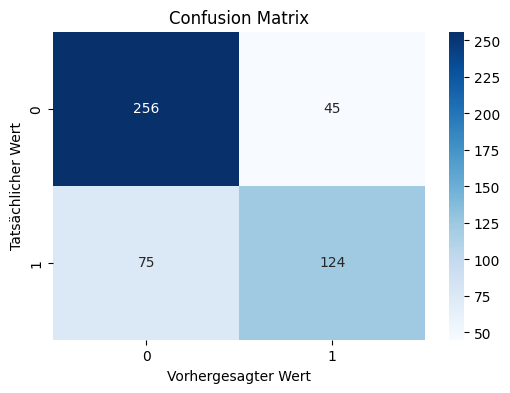

In [29]:
plt.figure(figsize=(6, 4))
sns.heatmap(metrics['conf_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Tatsächlicher Wert')
plt.xlabel('Vorhergesagter Wert')
plt.show()

## Model Step 1: Data Quality

Fix grammar error in column "Ctry" (Germayn -> Germany)

In [30]:
df_test_step_1 = pd.read_csv("../../data/processed/triathlon_watch_test_preprocessed_john.csv")

# Add hot encoded features
df_hot_encoded_feat = pd.get_dummies(df_test_step_1.filter(category_columns), 
                                     columns=category_columns, drop_first=True, 
                                     prefix="hot_enc_", dtype=int)
df_test_step_1 = pd.concat([df_test_step_1, df_hot_encoded_feat], axis=1)
df_test_step_1 = df_test_step_1.drop(category_columns + text_columns, axis=1)

df_train_step_1 = pd.read_csv("../../data/processed/triathlon_watch_training_preprocessed_john_prep_1.csv")

# Verify dataframe have the same number of columns
assert df_train_step_1.shape[1] == df_test_step_1.shape[1], "Columns mismatch between train and test dataset"

In [31]:
features = [col for col in list(df_train_step_1.columns) if col != target_columns[0]]

### Model Results

In [32]:
model, features, scores, metrics = train_and_evaluate_model(df_train=df_train_step_1, 
                             df_test=df_test_step_1, 
                             features=features,
                             remove_features=['most_current_software_update'],
                             target_col=target_columns[0])

models_metrics['step_1'] = {
    'model': model,
    'features': features,
    'scores': scores,
    'metrics': metrics
}

Features: ['age_of_customer', 'swimming_hours_per_week', 'biking_hours_per_week', 'running_hours_per_week', 'total_training_hours_per_week', 'vo2_max', '10k_running_time_prediction', 'calories_burned_per_week', 'support_cases_of_customer', 'customer_years', 'synchronisation', 'hot_enc__Male', 'hot_enc__Other', 'hot_enc__Germany', 'hot_enc__India', 'hot_enc__UK', 'hot_enc__USA', 'hot_enc__UnknownLand', 'hot_enc__Berlin', 'hot_enc__Birmingham', 'hot_enc__Brisbane', 'hot_enc__Chicago', 'hot_enc__Delhi', 'hot_enc__Hamburg', 'hot_enc__London', 'hot_enc__Los Angeles', 'hot_enc__Manchester', 'hot_enc__Melbourne', 'hot_enc__Mumbai', 'hot_enc__Munich', 'hot_enc__New York', 'hot_enc__Sydney', 'hot_enc__Fitness', 'hot_enc__Recreation', 'hot_enc__Evening', 'hot_enc__Morning', 'hot_enc__Free', 'hot_enc__Premium', 'hot_enc__White']
Training Score: 0.790
Test Score: 0.760
Classification Report:               precision    recall  f1-score   support

           0       0.77      0.85      0.81       30

### Feature Importance

In [33]:
feature_importance = feature_importance_logistic_regression(model, features)
feature_importance.head()

,feature,coeffiecient,abs_coeffiecient
16,hot_enc__USA,1.160806,1.160806
32,hot_enc__Fitness,-0.499387,0.499387
21,hot_enc__Chicago,0.411110,0.411110
15,hot_enc__UK,-0.402166,0.402166
30,hot_enc__New York,0.385413,0.385413


### Confusion Matrix

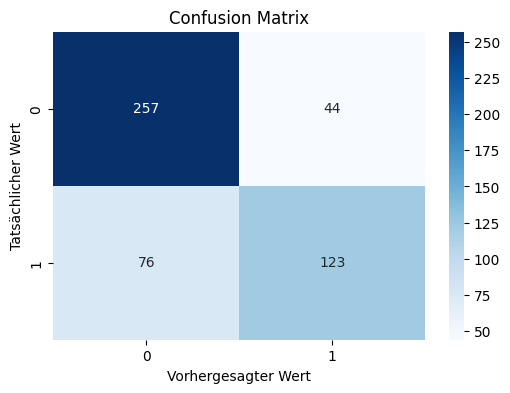

In [34]:
plt.figure(figsize=(6, 4))
sns.heatmap(metrics['conf_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Tatsächlicher Wert')
plt.xlabel('Vorhergesagter Wert')
plt.show()

## Model Step 2: Data Imputation

- All of the steps in Step 1. 
- Deletion of entries with missing values in the target colunm
- Listwise deletion (all rows with multiple missing values, more than 2)
- Outlier Cleaning
- Imputation for numerical columns
- Imputation for categorical columns
    - Imputation using mode
    - Imputation using Predictive model

In [35]:
df_test_step_2 = pd.read_csv("../../data/processed/triathlon_watch_test_preprocessed_john.csv")

# Add hot encoded features
df_hot_encoded_feat = pd.get_dummies(df_test_step_2.filter(category_columns), 
                                     columns=category_columns, drop_first=True, 
                                     prefix="hot_enc_", dtype=int)
df_test_step_2 = pd.concat([df_test_step_2, df_hot_encoded_feat], axis=1)
df_test_step_2 = df_test_step_2.drop(category_columns + text_columns, axis=1)

df_train_step_2 = pd.read_csv("../../data/processed/triathlon_watch_training_preprocessed_john_prep_2.csv")

# Verify dataframe have the same number of columns
assert df_train_step_2.shape[1] == df_test_step_2.shape[1], "Columns mismatch between train and test dataset"

In [36]:
features = [col for col in list(df_train_step_1.columns) if col != target_columns[0]]

### Model Results

In [37]:
model, features, scores, metrics = train_and_evaluate_model(df_train=df_train_step_2, 
                             df_test=df_test_step_2, 
                             features=features,
                             remove_features=['most_current_software_update'],
                             target_col=target_columns[0])

models_metrics['step_2'] = {
    'model': model,
    'features': features,
    'scores': scores,
    'metrics': metrics
}

Features: ['age_of_customer', 'swimming_hours_per_week', 'biking_hours_per_week', 'running_hours_per_week', 'total_training_hours_per_week', 'vo2_max', '10k_running_time_prediction', 'calories_burned_per_week', 'support_cases_of_customer', 'customer_years', 'synchronisation', 'hot_enc__Male', 'hot_enc__Other', 'hot_enc__Germany', 'hot_enc__India', 'hot_enc__UK', 'hot_enc__USA', 'hot_enc__UnknownLand', 'hot_enc__Berlin', 'hot_enc__Birmingham', 'hot_enc__Brisbane', 'hot_enc__Chicago', 'hot_enc__Delhi', 'hot_enc__Hamburg', 'hot_enc__London', 'hot_enc__Los Angeles', 'hot_enc__Manchester', 'hot_enc__Melbourne', 'hot_enc__Mumbai', 'hot_enc__Munich', 'hot_enc__New York', 'hot_enc__Sydney', 'hot_enc__Fitness', 'hot_enc__Recreation', 'hot_enc__Evening', 'hot_enc__Morning', 'hot_enc__Free', 'hot_enc__Premium', 'hot_enc__White']
Training Score: 0.797
Test Score: 0.764
Classification Report:               precision    recall  f1-score   support

           0       0.80      0.81      0.81       30

### Feature Importance

In [38]:
feature_importance = feature_importance_logistic_regression(model, features)
feature_importance.head()

,feature,coeffiecient,abs_coeffiecient
16,hot_enc__USA,1.261222,1.261222
32,hot_enc__Fitness,-0.577633,0.577633
33,hot_enc__Recreation,-0.487288,0.487288
30,hot_enc__New York,0.486654,0.486654
21,hot_enc__Chicago,0.402098,0.402098


### Confusion Matrix

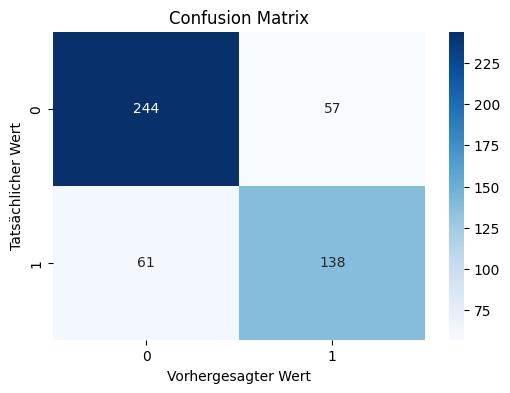

In [39]:
plt.figure(figsize=(6, 4))
sns.heatmap(metrics['conf_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Tatsächlicher Wert')
plt.xlabel('Vorhergesagter Wert')
plt.show()

## Model Step 3: Data Normalization

- All of the steps in Step 2. 
    - Normality Check & Quantile Transformation

In [40]:
# Normality check for numeric columns 
# Shapiro-Wilk Test
from scipy.stats import shapiro
from sklearn.preprocessing import QuantileTransformer

def shapiro_wilk_test(data: pd.DataFrame , alpha: float) -> bool:
    """Shapiro-Wilk Test for normality

    Args:
        data (pd.DataFrame): input data
        alpha (float): alpha value for significance test

    Returns:
        bool: p-values for normality test
    """
    stat, p = shapiro(data)
    print('\tStatistics=%.3f, p=%.5f' % (stat, p))
    if p > alpha:
        print('\tSample looks Gaussian (fail to reject H0)')
        return True
    else:
        print('\tSample does not look Gaussian (reject H0)')
        return False

def normality_check_and_quantile_transformation_test_data(df_train: pd.DataFrame, 
                                                df_test: pd.DataFrame,
                                                numeric_columns: list[str], 
                                                alpha: float) -> pd.DataFrame: 
    """Normality check for numeric columns and apply quantile transformation

    Args:
        df (pd.DataFrame): input dataframe
        numeric_columns (list[str]): numeric columns
        alpha (float): alpha value for significance test

    Returns:
        pd.DataFrame: transformed dataframe
    """
    numeric_columns_gaussian_check = {}
    for col in numeric_columns:
        print("Normality test for column: ", col)
        numeric_columns_gaussian_check[col] = shapiro_wilk_test(df_train[col],alpha)    
        
    org_name_transformed_cols = []
    # Quantile Transformation
    for col in numeric_columns:
        if numeric_columns_gaussian_check[col] == False:
            print("Transforming column: ", col)
            n_quantiles = int(np.sqrt(len(df_train[col])))
            qt = QuantileTransformer(n_quantiles=n_quantiles, 
                                    output_distribution='normal',
                                    random_state=0)
            
            trans_x=qt.fit_transform(np.array(df_test[col].array.reshape(-1, 1)))
            df_test[f'{col}_transformed']=trans_x
            org_name_transformed_cols.append(col)

    return df_test, org_name_transformed_cols

In [41]:
df_test_step_3 = pd.read_csv("../../data/processed/triathlon_watch_test_preprocessed_john.csv")

# Add hot encoded features
df_hot_encoded_feat = pd.get_dummies(df_test_step_3.filter(category_columns), 
                                     columns=category_columns, drop_first=True, 
                                     prefix="hot_enc_", dtype=int)
df_test_step_3 = pd.concat([df_test_step_3, df_hot_encoded_feat], axis=1)
df_test_step_3 = df_test_step_3.drop(category_columns + text_columns, axis=1)

In [42]:
df_train_step_3 = pd.read_csv("../../data/processed/triathlon_watch_training_preprocessed_john_prep_3.csv")

In [43]:
alpha = 0.05
df_test_step_3, org_name_transformed_cols = normality_check_and_quantile_transformation_test_data(df_train=df_train, 
                                                                                             df_test=df_test_step_3,
                                                                                             numeric_columns=numeric_columns, 
                                                                                             alpha=alpha)
df_test_step_3 = df_test_step_3.drop(org_name_transformed_cols, axis=1)

Normality test for column:  age_of_customer
	Statistics=nan, p=nan
	Sample does not look Gaussian (reject H0)
Normality test for column:  swimming_hours_per_week
	Statistics=nan, p=nan
	Sample does not look Gaussian (reject H0)
Normality test for column:  biking_hours_per_week
	Statistics=nan, p=nan
	Sample does not look Gaussian (reject H0)
Normality test for column:  running_hours_per_week
	Statistics=nan, p=nan
	Sample does not look Gaussian (reject H0)
Normality test for column:  total_training_hours_per_week
	Statistics=nan, p=nan
	Sample does not look Gaussian (reject H0)
Normality test for column:  vo2_max
	Statistics=nan, p=nan
	Sample does not look Gaussian (reject H0)
Normality test for column:  10k_running_time_prediction
	Statistics=nan, p=nan
	Sample does not look Gaussian (reject H0)
Normality test for column:  calories_burned_per_week
	Statistics=nan, p=nan
	Sample does not look Gaussian (reject H0)
Normality test for column:  support_cases_of_customer
	Statistics=nan, p

In [44]:
# Verify dataframe have the same number of columns
assert df_train_step_3.shape[1] == df_test_step_3.shape[1], "Columns mismatch between train and test dataset"

In [45]:
features = [col for col in list(df_train_step_3.columns) if col != target_columns[0]]

### Model Results

In [46]:
model, features, scores, metrics = train_and_evaluate_model(df_train=df_train_step_3, 
                             df_test=df_test_step_3, 
                             features=features,
                             remove_features=['most_current_software_update'],
                             target_col=target_columns[0])

models_metrics['step_3'] = {
    'model': model,
    'features': features,
    'scores': scores,
    'metrics': metrics
}

Features: ['synchronisation', 'age_of_customer_transformed', 'swimming_hours_per_week_transformed', 'biking_hours_per_week_transformed', 'running_hours_per_week_transformed', 'total_training_hours_per_week_transformed', 'vo2_max_transformed', '10k_running_time_prediction_transformed', 'calories_burned_per_week_transformed', 'support_cases_of_customer_transformed', 'customer_years_transformed', 'hot_enc__Male', 'hot_enc__Other', 'hot_enc__Germany', 'hot_enc__India', 'hot_enc__UK', 'hot_enc__USA', 'hot_enc__UnknownLand', 'hot_enc__Berlin', 'hot_enc__Birmingham', 'hot_enc__Brisbane', 'hot_enc__Chicago', 'hot_enc__Delhi', 'hot_enc__Hamburg', 'hot_enc__London', 'hot_enc__Los Angeles', 'hot_enc__Manchester', 'hot_enc__Melbourne', 'hot_enc__Mumbai', 'hot_enc__Munich', 'hot_enc__New York', 'hot_enc__Sydney', 'hot_enc__Fitness', 'hot_enc__Recreation', 'hot_enc__Evening', 'hot_enc__Morning', 'hot_enc__Free', 'hot_enc__Premium', 'hot_enc__White']
Training Score: 0.788
Test Score: 0.770
Classifica

### Feature Importance

In [47]:
feature_importance = feature_importance_logistic_regression(model, features)
feature_importance.head()

,feature,coeffiecient,abs_coeffiecient
16,hot_enc__USA,1.305655,1.305655
32,hot_enc__Fitness,-0.722222,0.722222
17,hot_enc__UnknownLand,-0.711060,0.711060
33,hot_enc__Recreation,-0.701440,0.701440
6,vo2_max_transformed,0.669014,0.669014


### Confusion Matrix

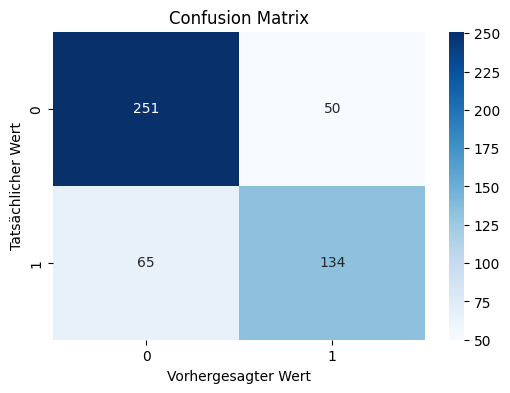

In [48]:
plt.figure(figsize=(6, 4))
sns.heatmap(metrics['conf_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Tatsächlicher Wert')
plt.xlabel('Vorhergesagter Wert')
plt.show()

## Model Step 4: Feature Engineering

- All of the steps in Step 3. 
- Combination of Features
- Multicoliniarity Test

In [49]:
df_test_step_4 = df_test_step_3.copy()

df_test_step_4['most_current_software_update'] = pd.to_datetime(df_test_step_4['most_current_software_update'])
df_test_step_4['most_current_software_update_month'] = df_test_step_4['most_current_software_update'].dt.month
df_test_step_4['most_current_software_update_day'] = df_test_step_4['most_current_software_update'].dt.day
df_test_step_4['most_current_software_update_year'] = df_test_step_4['most_current_software_update'].dt.year

df_test_step_4 = df_test_step_4.drop(date_columns, axis=1)

df_test_step_4_org = df_test_step_4.copy()

In [50]:
df_train_step_4 = pd.read_csv("../../data/processed/triathlon_watch_training_preprocessed_john_prep_4.csv")

# preselected features vis VIF
features = [col for col in df_train_step_4.columns if col != target_columns[0]]

df_test_step_4 = df_test_step_4[features + target_columns].copy()

# Verify dataframe have the same number of columns
assert df_train_step_4.shape[1] == df_test_step_4.shape[1], "Columns mismatch between train and test dataset"

### Model Results

In [51]:
model, features, scores, metrics = train_and_evaluate_model(df_train=df_train_step_4, 
                             df_test=df_test_step_4, 
                             features=features,
                             remove_features=['most_current_software_update'],
                             target_col=target_columns[0])

models_metrics['step_4'] = {
    'model': model,
    'features': features,
    'scores': scores,
    'metrics': metrics
}

Features: ['synchronisation', 'age_of_customer_transformed', 'swimming_hours_per_week_transformed', 'biking_hours_per_week_transformed', 'running_hours_per_week_transformed', 'vo2_max_transformed', '10k_running_time_prediction_transformed', 'support_cases_of_customer_transformed', 'customer_years_transformed', 'hot_enc__Male', 'hot_enc__Other', 'hot_enc__UnknownLand', 'hot_enc__Delhi', 'hot_enc__Mumbai', 'hot_enc__Fitness', 'hot_enc__Recreation', 'hot_enc__Evening', 'hot_enc__Morning', 'hot_enc__Free', 'hot_enc__Premium', 'hot_enc__White', 'most_current_software_update_month', 'most_current_software_update_day']
Training Score: 0.768
Test Score: 0.744
Classification Report:               precision    recall  f1-score   support

           0       0.78      0.81      0.79       301
           1       0.69      0.65      0.67       199

    accuracy                           0.74       500
   macro avg       0.73      0.73      0.73       500
weighted avg       0.74      0.74      0.74  

### Feature Importance

In [52]:
feature_importance = feature_importance_logistic_regression(model, features)
feature_importance.head()

,feature,coeffiecient,abs_coeffiecient
11,hot_enc__UnknownLand,-0.798014,0.798014
14,hot_enc__Fitness,-0.671788,0.671788
13,hot_enc__Mumbai,-0.618097,0.618097
15,hot_enc__Recreation,-0.614278,0.614278
5,vo2_max_transformed,0.576084,0.576084


### Confusion Matrix

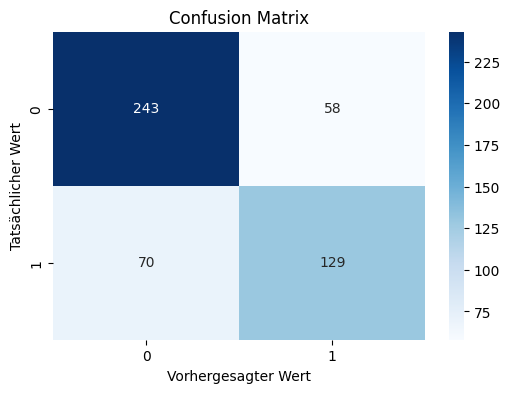

In [53]:
plt.figure(figsize=(6, 4))
sns.heatmap(metrics['conf_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Tatsächlicher Wert')
plt.xlabel('Vorhergesagter Wert')
plt.show()

## Model Step 5: Dimensionality Reduction using PCA

- All of the steps in Step 4, except the Multicoliniarity Test
- Apply PCA and keep 95% of variance

In [54]:
import pickle
with open('../../models/pca_transform_on_train_data.pkl', 'rb') as file:
    pca_transform = pickle.load(file)

In [55]:
df_train_step_5_pca = pd.read_csv("../../data/processed/triathlon_watch_training_preprocessed_john_prep_5.csv")

In [56]:
df_test_step_5 = df_test_step_4_org.copy()
features = pca_transform.feature_names_in_

X = df_test_step_5[features].copy()
Y = df_test_step_5[target_columns[0]].values
X_pca = pca_transform.transform(X)
df_test_step_5_pca = pd.concat([pd.DataFrame(X_pca), pd.DataFrame(Y, columns=target_columns) ], axis=1).reset_index(drop=True)

In [57]:
df_train_step_5_pca.shape, df_test_step_5_pca.shape

((978, 9), (500, 9))

In [58]:
# Verify dataframe have the same number of columns
assert df_train_step_5_pca.shape[1] == df_test_step_5_pca.shape[1], "Columns mismatch between train and test dataset"

### Model Results

In [59]:
features = [col for col in df_train_step_5_pca.columns if col != target_columns[0]]
df_test_step_5_pca.columns = df_train_step_5_pca.columns

In [60]:
model, features, scores, metrics = train_and_evaluate_model(df_train=df_train_step_5_pca, 
                             df_test=df_test_step_5_pca, 
                             features=features,
                             remove_features=[],
                             target_col=target_columns[0])

models_metrics['step_5'] = {
    'model': model,
    'features': features,
    'scores': scores,
    'metrics': metrics
}

Features: ['0', '1', '2', '3', '4', '5', '6', '7']
Training Score: 0.761
Test Score: 0.740
Classification Report:               precision    recall  f1-score   support

           0       0.77      0.81      0.79       301
           1       0.69      0.63      0.66       199

    accuracy                           0.74       500
   macro avg       0.73      0.72      0.72       500
weighted avg       0.74      0.74      0.74       500

Cross Validation Scores: [0.76530612 0.69897959 0.76020408 0.75384615 0.74358974]


### Feature Importance

In [61]:
feature_importance = feature_importance_logistic_regression(model, features)
feature_importance.head()

,feature,coeffiecient,abs_coeffiecient
4,4,0.412526,0.412526
5,5,-0.313239,0.313239
3,3,-0.295252,0.295252
6,6,0.227235,0.227235
7,7,-0.144587,0.144587


### Confusion Matrix

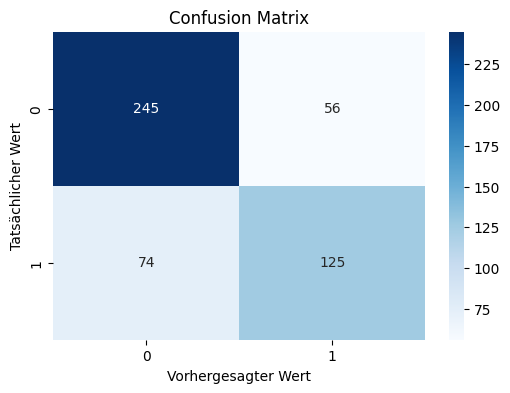

In [62]:
plt.figure(figsize=(6, 4))
sns.heatmap(metrics['conf_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Tatsächlicher Wert')
plt.xlabel('Vorhergesagter Wert')
plt.show()

## Results Analysis

Here we analyze the results of all the models. 

In [71]:
model_types = list(models_metrics.keys())

results = {'Model_Type':[], 'F1 Score':[], 'Accuracy Score':[]}
for model_type in model_types:
    
    results['Model_Type'].append(model_type)
    results['F1 Score'].append(round(models_metrics[model_type]['metrics']['f1_score'], 3))
    results['Accuracy Score'].append(models_metrics[model_type]['metrics']['accuracy_score'])
    print(f"Model Type: {model_type}")
    print(f"F1_Score: {round(models_metrics[model_type]['metrics']['f1_score'], 3)}")
    print(f"Accuracy Score: {models_metrics[model_type]['metrics']['accuracy_score']}")
    print()
    
df_results = pd.DataFrame(results)

Model Type: step_0
F1_Score: 0.674
Accuracy Score: 0.76

Model Type: step_1
F1_Score: 0.672
Accuracy Score: 0.76

Model Type: step_2
F1_Score: 0.701
Accuracy Score: 0.764

Model Type: step_3
F1_Score: 0.7
Accuracy Score: 0.77

Model Type: step_4
F1_Score: 0.668
Accuracy Score: 0.744

Model Type: step_5
F1_Score: 0.658
Accuracy Score: 0.74



In [72]:
df_results

,Model_Type,F1 Score,Accuracy Score
0,step_0,0.674,0.760
1,step_1,0.672,0.760
2,step_2,0.701,0.764
3,step_3,0.700,0.770
4,step_4,0.668,0.744
5,step_5,0.658,0.740


We can observe that the two best models are those corresponding to the data pre-processing of **Step 2** (data imputation and outlier cleaning) and **Step 3** (data normalisation). The F1 values of the **Step 2** and **Step 3** models are 0.701 and 0.7 respectively. Meanwhile, the accuracy values are 0.764 and 0.770. 

This means that the data with full data quality and also the normalised data can deliver top results. We will take this forward to future versions to validate on other different models. 